# Bayesian inference of the parameters of a ZIP distribution using JAGS

In this R Jupyter notebook, the parameters of a **Zero-Inflated Poisson (ZIP) distribution** are inferred using a Bayesian approach with JAGS.

A ZIP distribution is a mixture model where the number of zeros has been artificially increased compared to a standard Poisson distribution. The first process (or component) generates zeros and the second process is governed by a Poisson distribution that generates counts, some of which may be zero.

The probability of extra zeros is denoted $\pi$ and the mean of the Poisson distribution is denoted $\lambda$.

In [1]:
# Import the required libraries
library(MCMCvis)
library(rjags)
library(ggplot2)

Loading required package: coda

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs



In [2]:
# Ensure the figures are easy to view in the notebook
options(repr.plot.width=10, repr.plot.height=6)

## Data generation

In [3]:
# Probability of extra zeros
pi <- 0.4

# Mean of the Poisson distribution
lambda <- 5

# Number of samples to generate
N <- 200

In [4]:
# Generate N zeros
zeros <- rep(0, N)

# Generate N samples from a Poisson distribution
counts <- rpois(N, lambda)

# Component at each sample
component_samples <- rbinom(N, 1, pi)

# Samples from the ZIP distribution
samples <- component_samples * zeros + (1-component_samples) * counts

In [5]:
# Calculate the empirical pi
empirical_pi <- mean(component_samples)
empirical_pi

[1] 0.42

In [6]:
# Calculate the empirical lambda
empirical_lambda <- mean(counts[component_samples == 0])
empirical_lambda

[1] 4.698276

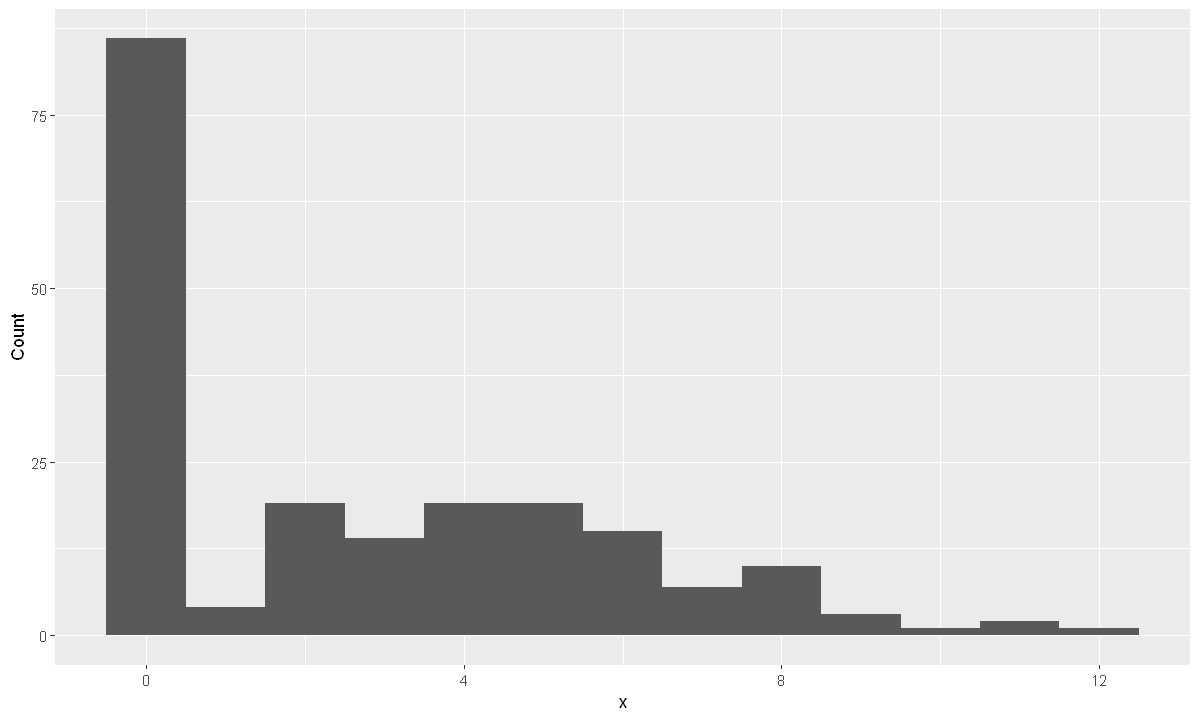

In [7]:
# Plot a histogram of the samples
df <- data.frame(x=samples)

ggplot(df, aes(x=x)) + 
    geom_histogram(binwidth=1) +
    ylab("Count")

## Bayesian inference of parameters

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 200
   Unobserved stochastic nodes: 202
   Total graph size: 1206

Initializing model



Warning message in MCMCsummary(samp, round = 2):
"Rhat statistic cannot be calculated with one chain. NAs inserted."


,mean,sd,2.5%,50%,97.5%,Rhat,n.eff
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>
lambda,4.74,0.21,4.34,4.74,5.15,NA,11304
pi,0.43,0.03,0.36,0.43,0.50,NA,19415


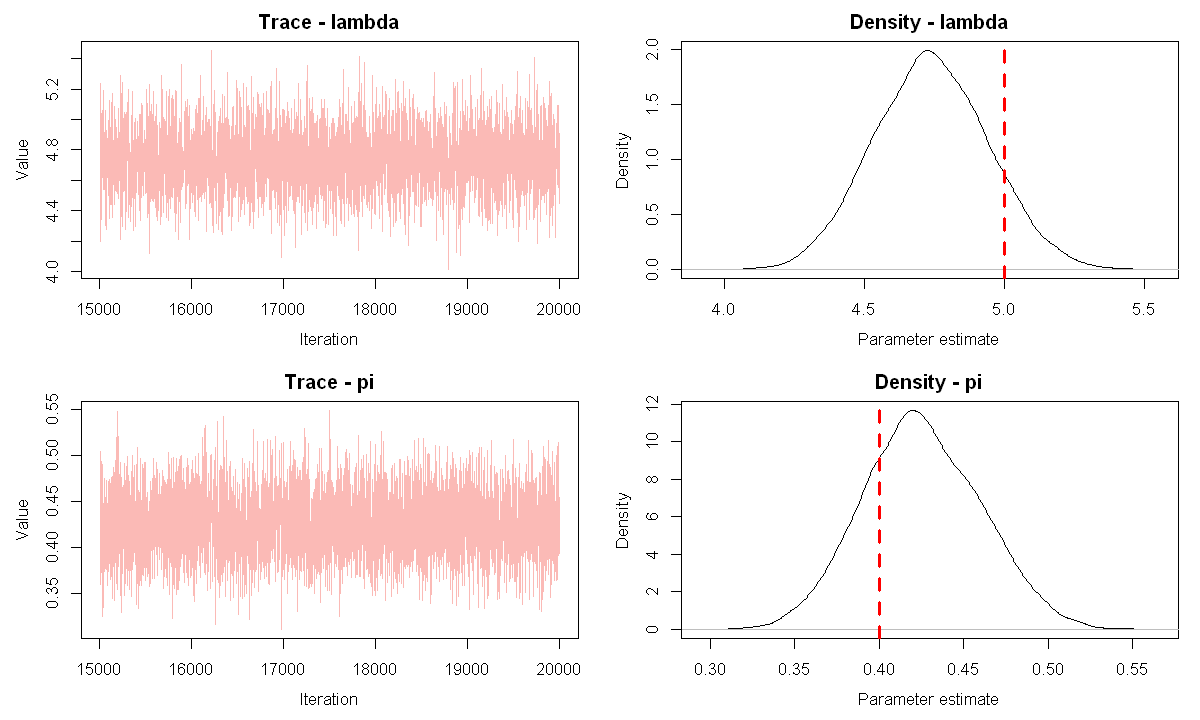

In [8]:
# Infer the parameters of the ZIP distribution using JAGS
model_string <- "
model {
    # Prior for the mean of the Poisson distribution
    lambda ~ dgamma(1, 0.1)

    # Prior for pi
    pi ~ dbeta(1, 1)

    # Likelihood
    for (i in 1:N) {

        # Is the sample drawn from the zero-inflated component?
        zero[i] ~ dbern(pi)

        # Lambda of the Poisson distribution
        # (1e-10 because a value of zero is invalid)
        lambda_zip[i] <- (zero[i]*1e-10) + (1-zero[i])*lambda
    
        # Sample from the Poisson distribution where the mean has
        # been modulated
        y[i] ~ dpois(lambda_zip[i])
    }
}
"

model = jags.model(textConnection(model_string),
                   data = list(y=samples, N=length(samples)))

update(model, 10000, progress.bar="none")

samp <- coda.samples(model, 
                     variable.names=c("lambda", "pi"), 
                     n.iter=20000, progress.bar="none")

# Show a summary of the variables
MCMCsummary(samp, round = 2)

MCMCtrace(samp, 
          gv=c(lambda, pi),
          pdf=FALSE)

The empirical values can be compared to the inferred values.

In [9]:
empirical_lambda

[1] 4.698276

In [10]:
median(as.matrix(samp)[, "lambda"])

[1] 4.740108

In [11]:
empirical_pi

[1] 0.42

In [12]:
median(as.matrix(samp)[, "pi"])

[1] 0.425318